In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

In [2]:
# Hardcoded :( but top companies to track
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'BRK-B', 'TSLA', 'LLY', 'UNH',
    'JPM', 'V', 'JNJ', 'PG', 'HD', 'MA', 'XOM', 'MRK', 'AVGO', 'COST',
    'ABBV', 'WMT', 'ADBE', 'PEP', 'CVX', 'KO', 'CRM', 'NFLX', 'ACN', 'ABT',
    'MCD', 'AMD', 'TMO', 'INTC', 'LIN', 'DHR', 'ORCL', 'TXN', 'NEE', 'AMGN',
    'PFE', 'QCOM', 'NKE', 'UPS', 'MS', 'MDT', 'PM', 'BA', 'HON', 'UNP'
]

In [3]:
# Data window
start_date = "2005-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start_date, end_date)['Close']
data = data.dropna(axis=1, how="all")

/var/folders/37/92g854mn0y75ft49m9xr6t9w0000gn/T/ipykernel_40969/2841868217.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start_date, end_date)['Close']
[*********************100%***********************]  50 of 50 completed


In [4]:
returns = data.pct_change().dropna()

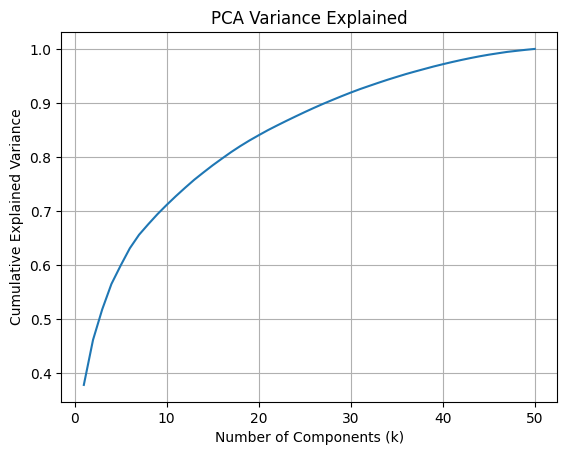

In [12]:
pca = PCA()
pca.fit(returns)

from matplotlib import pyplot as plt
cum_var = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(cum_var)+1), cum_var)
plt.xlabel('Number of Components (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)

k = (cum_var >= 0.85).argmax() + 1

In [13]:
print(k)

22


In [ ]:
proj = pca.transform(returns)[:, :k] # Project
recon = proj @ pca.components_[:k, :] # Reconstruct
res = returns - recon

2.7031464108965406


In [ ]:
# Volatility Calculations
window = 10
vol = np.zeros_like(returns[window:])
for i in range(len(returns) - window):
    vol[i] = np.std(returns[i:i+window], axis=0)
print(vol.shape)

# reshape returns and residuals to window shape
returns = returns[window:]
res = res[window:]

(3009, 50)
(3009, 50)
